<a href="https://colab.research.google.com/github/Niloy-24/Transfer-Learning-Based-Classification-Of-Eye-Disease/blob/main/ResNet50_NormalVsUvetis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
PATH = '/content/gdrive/MyDrive/Thesis/Data/NormalVsUvetis/'
train_dir = os.path.join(PATH, 'Train')
test_dir = os.path.join(PATH, 'Test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1469 files belonging to 2 classes.


In [4]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 386 files belonging to 2 classes.


['Normal', 'Uveitis']


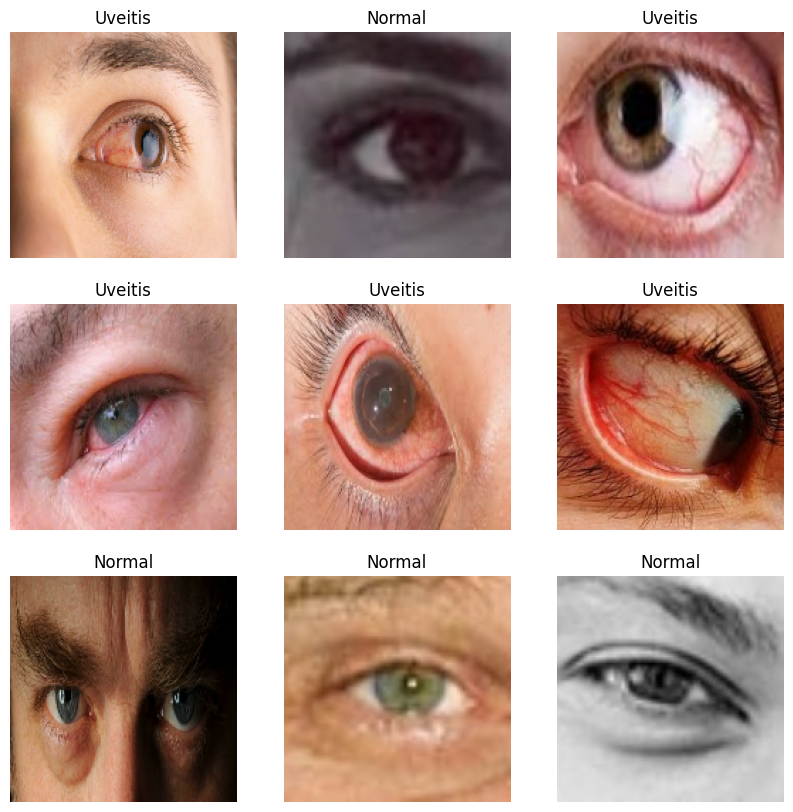

In [5]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
test_batches = tf.data.experimental.cardinality(test_dataset)
val_dataset = test_dataset.take(test_batches // 7)
val_dataset = test_dataset.skip(test_batches // 7)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 12
Number of test batches: 13


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

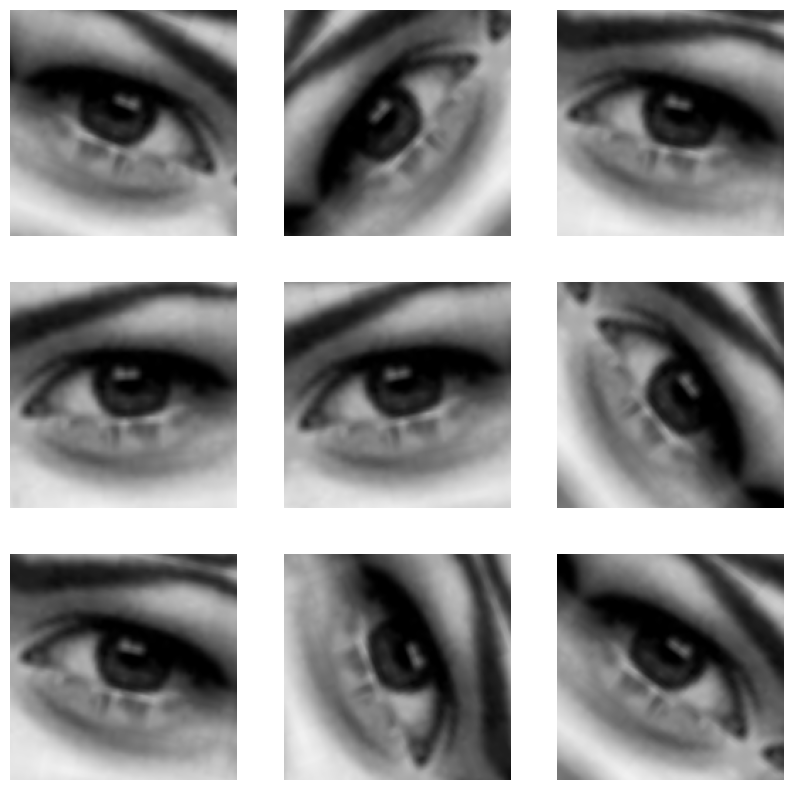

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.resnet50.ResNet50
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(val_dataset)

12/12 [==============================] - 64s 1s/step - loss: 4.6322 - accuracy: 0.5734


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.63
initial accuracy: 0.57


In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/50
46/46 [==============================] - 95s 2s/step - loss: 4.6236 - accuracy: 0.5929 - val_loss: 3.8239 - val_accuracy: 0.6525
Epoch 2/50
46/46 [==============================] - 5s 107ms/step - loss: 3.9800 - accuracy: 0.6467 - val_loss: 3.8180 - val_accuracy: 0.6328
Epoch 3/50
46/46 [==============================] - 6s 124ms/step - loss: 3.7539 - accuracy: 0.6773 - val_loss: 3.5062 - val_accuracy: 0.6638
Epoch 4/50
46/46 [==============================] - 5s 108ms/step - loss: 3.2890 - accuracy: 0.6998 - val_loss: 3.5797 - val_accuracy: 0.6723
Epoch 5/50
46/46 [==============================] - 7s 132ms/step - loss: 3.2723 - accuracy: 0.7080 - val_loss: 3.4373 - val_accuracy: 0.6638
Epoch 6/50
46/46 [==============================] - 5s 109ms/step - loss: 3.3622 - accuracy: 0.7018 - val_loss: 3.4505 - val_accuracy: 0.6610
Epoch 7/50
46/46 [==============================] - 6s 128ms/step - loss: 2.8611 - accuracy: 0.7406 - val_loss: 3.4279 - val_accuracy: 0.6695
Epoch 8/

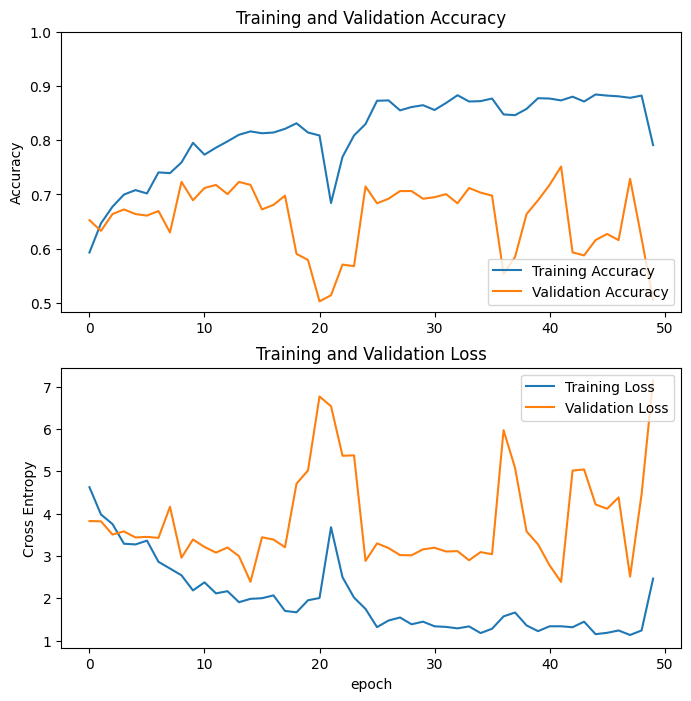

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
base_model.trainable = True

In [26]:
len(model.layers[2].layers)

175

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[2].layers[fine_tune_at:]:
  layer.trainable = True

Number of layers in the base model:  6


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

In [30]:
len(model.trainable_variables)

214

In [31]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 50/100
46/46 [==============================] - 48s 301ms/step - loss: 1.1686 - accuracy: 0.8965 - val_loss: 2.5132 - val_accuracy: 0.7853
Epoch 51/100
46/46 [==============================] - 11s 223ms/step - loss: 0.5746 - accuracy: 0.9469 - val_loss: 3.2858 - val_accuracy: 0.7401
Epoch 52/100
46/46 [==============================] - 12s 248ms/step - loss: 0.5620 - accuracy: 0.9544 - val_loss: 4.4914 - val_accuracy: 0.6864
Epoch 53/100
46/46 [==============================] - 11s 227ms/step - loss: 0.5188 - accuracy: 0.9571 - val_loss: 1.9744 - val_accuracy: 0.8531
Epoch 54/100
46/46 [==============================] - 11s 226ms/step - loss: 0.4485 - accuracy: 0.9612 - val_loss: 1.6750 - val_accuracy: 0.8785
Epoch 55/100
46/46 [==============================] - 11s 233ms/step - loss: 0.3968 - accuracy: 0.9660 - val_loss: 4.9460 - val_accuracy: 0.6328
Epoch 56/100
46/46 [==============================] - 12s 243ms/step - loss: 0.3883 - accuracy: 0.9687 - val_loss: 4.9057 - val_ac

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

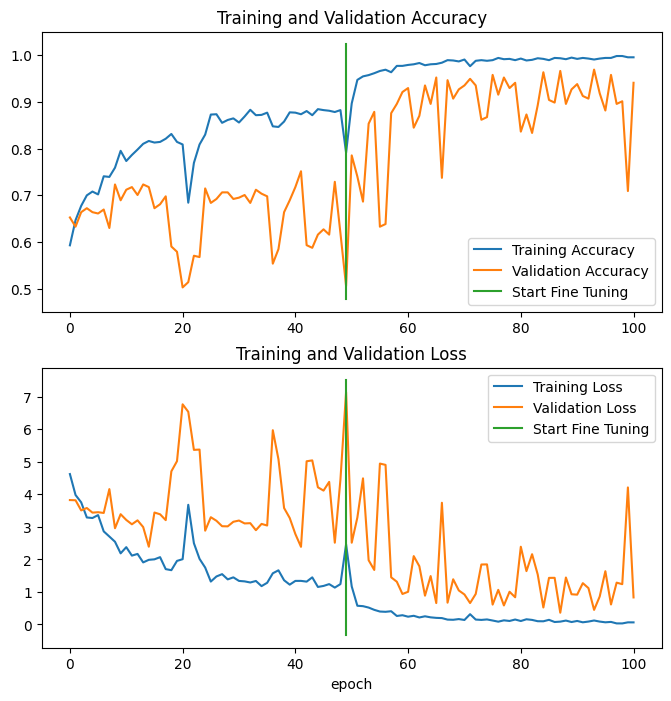

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

13/13 [==============================] - 2s 80ms/step - loss: 0.9593 - accuracy: 0.9326
Test accuracy : 0.9326424598693848


Predictions:
 [0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0]
Labels:
 [0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0]


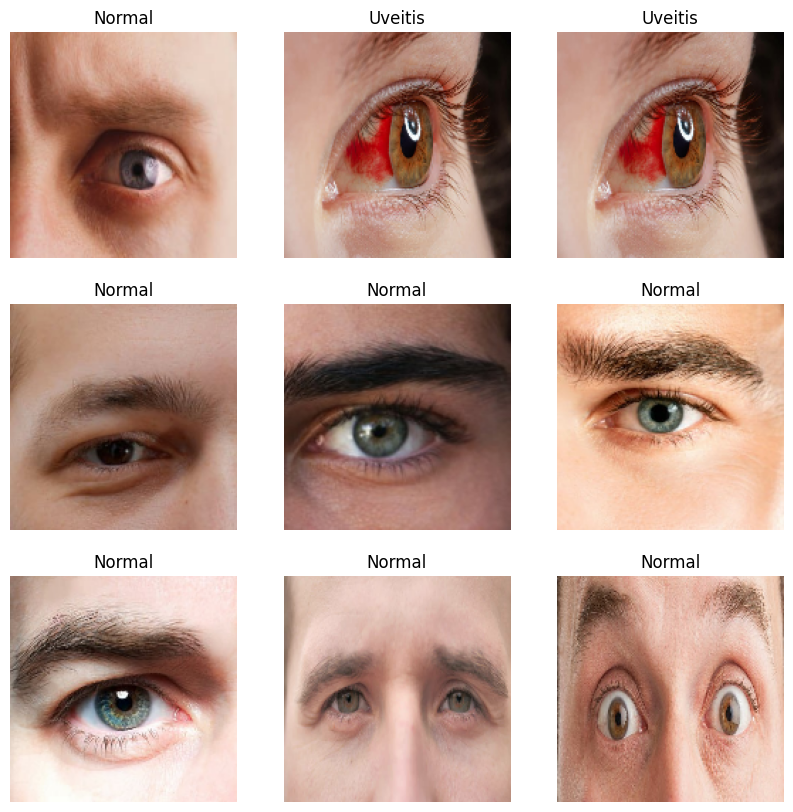

In [35]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [36]:
len(list(test_dataset))

13

In [37]:
# True labels
true_labels = []
for batch in test_dataset:
    labels = batch[1]  # Assuming labels are the second component of each batch
    true_labels.extend(labels.numpy().tolist())

# Predicted labels
predicted_labels = model.predict(test_dataset)
predicted_labels = tf.nn.sigmoid(predicted_labels)
predicted_labels = tf.where(predicted_labels < 0.5, 0, 1)

# Calculate true positives, true negatives, false positives, and false negatives
true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 1), tf.equal(predicted_labels, 1)), tf.float32))
true_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 0), tf.equal(predicted_labels, 0)), tf.float32))
false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 0), tf.equal(predicted_labels, 1)), tf.float32))
false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 1), tf.equal(predicted_labels, 0)), tf.float32))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(true_labels, predicted_labels), tf.float32))

# Calculate True Positive Rate (TPR) or Recall
tpr = true_positives / (true_positives + false_negatives)

# Calculate True Negative Rate (TNR)
tnr = true_negatives / (true_negatives + false_positives)

# Calculate False Positive Rate (FPR)
fpr = false_positives / (false_positives + true_negatives)

# Calculate False Negative Rate (FNR)
fnr = false_negatives / (false_negatives + true_positives)

# Calculate Precision
precision = true_positives / (true_positives + false_positives)

# Calculate F1 Score
f1_score = 2 * ((precision * tpr) / (precision + tpr))

# Print the performance metrics

print("True Positive Rate (TPR) or Recall:", tpr.numpy())
print("True Negative Rate (TNR):", tnr.numpy())
print("False Positive Rate (FPR):", fpr.numpy())
print("False Negative Rate (FNR):", fnr.numpy())
print("Precision:", precision.numpy())
print("F1 Score:", f1_score.numpy())

13/13 [==============================] - 3s 101ms/step
True Positive Rate (TPR) or Recall: 0.5466321
True Negative Rate (TNR): 0.4533679
False Positive Rate (FPR): 0.5466321
False Negative Rate (FNR): 0.4533679
Precision: 0.4818653
F1 Score: 0.5122094


In [38]:
predicted_labels

<tf.Tensor: shape=(386, 1), dtype=int32, numpy=
array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
    

In [39]:
true_labels

[1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,


In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate true positive rate (TPR) or recall
tpr = tp / (tp + fn)
print("True Positive Rate (TPR):", tpr)

# Calculate true negative rate (TNR)
tnr = tn / (tn + fp)
print("True Negative Rate (TNR):", tnr)

# Calculate false positive rate (FPR)
fpr = fp / (fp + tn)
print("False Positive Rate (FPR):", fpr)

# Calculate false negative rate (FNR)
fnr = fn / (fn + tp)
print("False Negative Rate (FNR):", fnr)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
print("Precision:", precision)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)


True Positive Rate (TPR): 0.543010752688172
True Negative Rate (TNR): 0.45
False Positive Rate (FPR): 0.55
False Negative Rate (FNR): 0.45698924731182794
Precision: 0.4786729857819905
F1 Score: 0.508816120906801


In [41]:
from tensorflow.keras.models import load_model

model.save('/content/gdrive/MyDrive/Saved_Model/ResNet50_NormalVsUvetis.h5')